In [ ]:
pip install emoji

In [ ]:
pip install contractions

In [ ]:
!pip install vaderSentiment

In [ ]:
pip install lazypredict

In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from dateutil.parser import parse
import re
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim import matutils
import contractions
from nltk.sentiment import SentimentIntensityAnalyzer
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import seaborn as sns

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [7]:
# Read the dataset
from google.colab import files
import io

uploaded = files.upload()

Saving reviews.json to reviews.json


In [40]:
# Specify the path to the JSON file
file_path = 'reviews.json'

# Read the JSON file
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

# Convert the JSON data to a pandas DataFrame
df = pd.DataFrame(data)


Check the dataset. We are mainly interested in rating and review columns.

In [41]:
df.head(3)

,datetime,review,rating,agent_response,review_id
0,2022-09-02T12:00:00,"The online banking system is fantastic, very u...",5,None,212505714577954497043972085218791026500
1,2022-09-04T17:30:00,I had an issue with my credit card and the cus...,2,None,105359736848155783777388746446191905864
2,2022-10-06T10:45:00,I recently took out a car loan and the interes...,4,None,82010988205544338312264831612888037873


A significant portion of the customer comments has a rating of 5. This implies that a considerable number of customers express high levels of satisfaction.

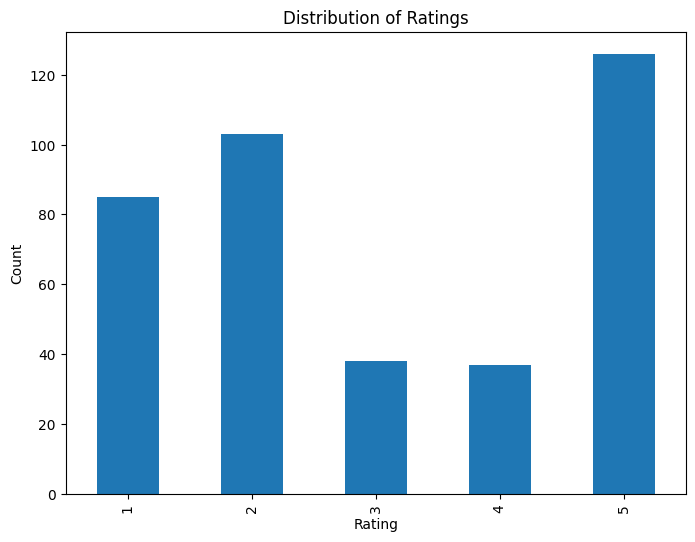

In [42]:
# Convert the "rating" column to numeric
df['rating'] = pd.to_numeric(df['rating'])

# Create a bar plot
plt.figure(figsize=(8, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

In [43]:
# Convert the "datetime" column to datetime format
#df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
# Convert the "datetime" column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce',  utc=True)

We notice that most of the comments are 5 stars but there are many comments with 1 and 2 stars.

In [44]:
# Create a new column for year
df['year'] = df['datetime'].dt.year

In [45]:
df.head(5)

,datetime,review,rating,agent_response,review_id,year
0,2022-09-02 12:00:00+00:00,"The online banking system is fantastic, very u...",5,None,212505714577954497043972085218791026500,2022
1,2022-09-04 17:30:00+00:00,I had an issue with my credit card and the cus...,2,None,105359736848155783777388746446191905864,2022
2,2022-10-06 10:45:00+00:00,I recently took out a car loan and the interes...,4,None,82010988205544338312264831612888037873,2022
3,2022-10-10 15:00:00+00:00,The ATM machines always seem to have plenty of...,5,None,69154301694811808702660880573121289369,2022
4,2022-11-05 08:00:00+00:00,The customer service team is always so friendl...,5,None,181891475788559994500106165952297747455,2022


In [46]:
# Create a new column for month
df['month'] = df['datetime'].dt.month

Conduct an examination of the average ratings per month.

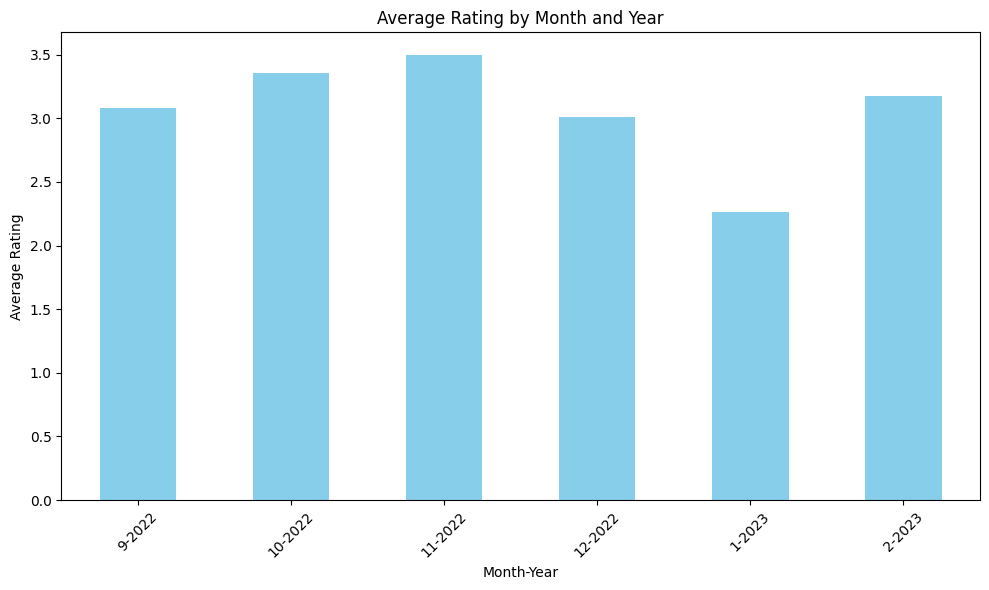

In [15]:
# Group the data by month and year, calculate the average rating, and sort by month-year
avg_rating_by_month_year = df.groupby(['year', 'month'])['rating'].mean().sort_index()

# Convert the index (year, month) to a string in the format "Month-Year"
avg_rating_by_month_year.index = avg_rating_by_month_year.index.map(lambda x: f"{x[1]}-{x[0]}")

# Create a bar plot
plt.figure(figsize=(10, 6))
avg_rating_by_month_year.plot(kind='bar', color='skyblue')
plt.xlabel('Month-Year')
plt.ylabel('Average Rating')
plt.title('Average Rating by Month and Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It seems that the January was not a good month. The average rating for this month is the lowest among the other months of the dataset.

We also examined the total number of comments received for each month. It was observed that the number of comments experienced a significant increase in the month of February,

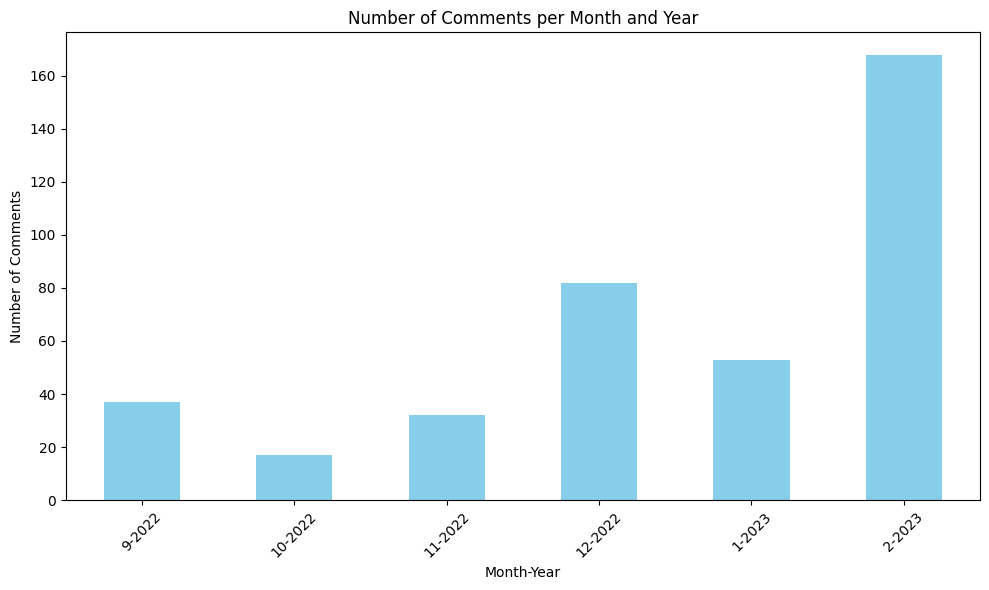

In [16]:
# Group the data by month and year, count the number of comments, and sort by month-year
comments_by_month_year = df.groupby(['year', 'month'])['review'].count().sort_index()

# Convert the index (year, month) to a string in the format "Month-Year"
comments_by_month_year.index = comments_by_month_year.index.map(lambda x: f"{x[1]}-{x[0]}")

# Create a bar plot
plt.figure(figsize=(10, 6))
comments_by_month_year.plot(kind='bar', color='skyblue')
plt.xlabel('Month-Year')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Month and Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The number of comments for February is much higher than the other months.

In [17]:
# Calculate the number of characters in the "review" column
df['review_length'] = df['review'].str.len()

# Calculate the minimum, average, and maximum number of characters
min_length = df['review_length'].min()
avg_length = df['review_length'].mean()
max_length = df['review_length'].max()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Min Length': [min_length], 'Avg Length': [avg_length], 'Max Length': [max_length]})

# Display the table
print(stats_df)

   Min Length  Avg Length  Max Length
0           1      124.17         640


There is a comment with one character. Probably an error? Let's check.

In [18]:
# Find the comment(s) with the minimum length of one character
min_length_comments = df[df['review_length'] == 1]['review']

# Display the comment(s)
print(min_length_comments)

280    😊
281    🙁
282    😍
283    😡
284    😎
285    😕
286    😜
287    🤔
288    😔
289    😱
290    😴
291    🙂
292    🙃
293    🤗
294    😇
295    😷
296    🤐
297    😜
Name: review, dtype: object


Emojis.. Ok I think it's bad. I am not sure how I will deal with this issue later. I would prefer not remove emojis. I hope there is a library to conver emojis to comments.

Check the number of NAs

In [47]:
# Calculate the number of missing values in each column
na_counts = df.isna().sum()

# Print the results
for column, count in na_counts.items():
    print(f"Column '{column}': {count} missing values")

Column 'datetime': 0 missing values
Column 'review': 0 missing values
Column 'rating': 0 missing values
Column 'agent_response': 384 missing values
Column 'review_id': 0 missing values
Column 'year': 0 missing values
Column 'month': 0 missing values


There are no missing values except for the agent_response.

We will start with the first question of the exercise. The first steps is  the Data preprocessing: Clean the customer feedback data by removing punctuation, stopwords, and performing other necessary text preprocessing steps.
We already know that there emojis.

In [48]:
def preprocess_text(text):
    # Remove emojis by replacing them with an empty string
    text = emoji.demojize(text)
    text = re.sub(r':[a-zA-Z_]+:', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text into words
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

In [49]:
# Apply the preprocessing function to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [50]:
# Print the preprocessed data
print(df['cleaned_review'])

0      online banking system fantastic userfriendly a...
1      issue credit card customer service team took f...
2      recently took car loan interest rate reasonabl...
3      atm machine always seem plenty cash need withd...
4      customer service team always friendly helpful ...
                             ...                        
384    recently switched app impressed security featu...
385    app userfriendly competitor apps interface cou...
386    using app everything need manage finance thing...
387    recently switched app pleased design sleek eas...
388    really like app lack certain feature competito...
Name: cleaned_review, Length: 389, dtype: object


Check the most common words in order to remove them. Although we have removed many stop words etc I think we can improve the dataset.

In [51]:
from collections import Counter
# Concatenate all preprocessed texts into a single string
all_texts = ' '.join(df['cleaned_review'])

# Tokenize the text into words
tokens = all_texts.split()

# Count the occurrences of each word
word_counts = Counter(tokens)

# Get the most common words
most_common_words = word_counts.most_common(50)

# Print the most common words
for word, count in most_common_words:
    print(word, count)

bank 192
app 91
notification 69
service 60
loan 53
banking 52
customer 47
issue 45
would 42
make 40
security 38
need 37
recently 35
great 34
feature 34
account 33
time 33
like 33
rate 32
keep 32
really 32
inflation 31
mobile 30
interest 29
use 29
transaction 29
agent 28
could 28
call 27
apps 27
push 27
order 26
support 26
payment 26
option 26
never 25
using 25
center 25
receive 24
installment 24
standing 24
fantastic 22
helpful 22
information 22
system 21
always 21
disappointed 21
offer 21
insurance 21
also 21


I think that some words do not add any value to our analysis. Therefore I will remove them

In [52]:
# List of words to remove
words_to_remove = ["bank", "would", "really", "could", "also"]

# Function to remove specific words from the text
def remove_words(text):
    # Tokenize the text into words
    tokens = text.split()

    # Remove the specified words
    filtered_tokens = [token for token in tokens if token not in words_to_remove]

    # Join the tokens back into text
    processed_text = ' '.join(filtered_tokens)

    return processed_text

# Remove specific words from the 'cleaned_review' column
df['cleaned_review'] = df['cleaned_review'].apply(remove_words)

b. We can continue with the next step. Vectorize the text: Convert the preprocessed text into numerical feature vectors using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or Count Vectorization.

In [64]:
# Create the Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the raw documents
count_matrix = count_vectorizer.fit_transform(df['cleaned_review'])

# Convert the count matrix to a gensim corpus
corpus = matutils.Sparse2Corpus(count_matrix.transpose())

# Create a dictionary mapping word IDs to words
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

# Train the LDA model
num_topics = 8 # Specify the number of topics
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Get the feature names from the Count Vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Define the number of top words to display for each topic
num_words = 5

In [65]:
# Display the top words for each topic
for i, topic in enumerate(lda_model.get_topics()):
    top_words = [feature_names[j] for j in topic.argsort()[:-num_words - 1:-1]]
    print(f"Topic {i+1}:")
    print(top_words)
    print()

Topic 1:
['service', 'recently', 'rate', 'loan', 'customer']

Topic 2:
['app', 'mobile', 'using', 'banking', 'service']

Topic 3:
['notification', 'make', 'transaction', 'push', 'finance']

Topic 4:
['notification', 'push', 'account', 'saving', 'banking']

Topic 5:
['app', 'account', 'notification', 'customer', 'issue']

Topic 6:
['apps', 'app', 'make', 'like', 'feature']

Topic 7:
['loan', 'installment', 'order', 'standing', 'failed']

Topic 8:
['inflation', 'app', 'support', 'agent', 'banking']



Step c, which is the next step in the topic clustering analysis, involves using the LDA model to assign topics to each feedback document.

In [66]:
# Convert the sparse matrix to a dense matrix
count_matrix_dense = count_matrix.toarray()

# Assign topics to documents
document_topics = []
for i, document in enumerate(count_matrix_dense):
    # Get the word frequencies in the document
    word_freqs = [(j, freq) for j, freq in enumerate(document) if freq > 0]
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(word_freqs)
    # Sort the topic distribution in descending order by probability
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    # Get the topic with the highest weight
    top_topic = topic_distribution[0][0]
    # Append the top topic to the list of document topics
    document_topics.append(top_topic)

# Add the document topics as a new column in the DataFrame
df['topic'] = document_topics

In [67]:
df

,datetime,review,rating,agent_response,review_id,year,month,cleaned_review,topic
0,2022-09-02 12:00:00+00:00,"The online banking system is fantastic, very u...",5,None,212505714577954497043972085218791026500,2022,9,online banking system fantastic userfriendly a...,7
1,2022-09-04 17:30:00+00:00,I had an issue with my credit card and the cus...,2,None,105359736848155783777388746446191905864,2022,9,issue credit card customer service team took f...,0
2,2022-10-06 10:45:00+00:00,I recently took out a car loan and the interes...,4,None,82010988205544338312264831612888037873,2022,10,recently took car loan interest rate reasonabl...,0
3,2022-10-10 15:00:00+00:00,The ATM machines always seem to have plenty of...,5,None,69154301694811808702660880573121289369,2022,10,atm machine always seem plenty cash need withd...,4
4,2022-11-05 08:00:00+00:00,The customer service team is always so friendl...,5,None,181891475788559994500106165952297747455,2022,11,customer service team always friendly helpful ...,0
...,...,...,...,...,...,...,...,...,...
384,2022-11-12 17:30:00+00:00,I recently switched to this app and I'm very i...,5,None,14894383988509482089889582079119054502,2022,11,recently switched app impressed security featu...,5
385,2022-12-15 16:00:00+00:00,This app is not as user-friendly as some of th...,2,None,127170772325680849798086740132064502765,2022,12,app userfriendly competitor apps interface use...,7
386,2022-12-03 14:00:00+00:00,I've been using this app for a while now and i...,4,None,12382012265226623578294818238145415288,2022,12,using app everything need manage finance thing...,5
387,2023-02-13 21:25:30+00:00,I recently switched to this app and I'm very p...,5,None,94202863281272678054836973708481421059,2023,2,recently switched app pleased design sleek eas...,5


Step D check results and look for insightful information.

Topic Distribution Bar Chart:
This plot shows the distribution of topics in your dataset. Each bar represents a topic, and the height of the bar represents the frequency or proportion of documents assigned to that topic. Y

In [68]:
# Assuming you have an LDA model called 'lda_model' and want to show the top words for topic number 5
topic_num = 0
num_words = 10  # Number of top words to display

# Get the top words for the specified topic
top_words = lda_model.show_topic(topic_num, topn=num_words)

# Print the top words
print(f"Top words for Topic {topic_num}:")
for word, prob in top_words:
    print(f"{word} (Probability: {prob:.3f})")

Top words for Topic 0:
service (Probability: 0.032)
recently (Probability: 0.027)
rate (Probability: 0.023)
loan (Probability: 0.021)
customer (Probability: 0.020)
happy (Probability: 0.015)
increase (Probability: 0.013)
issue (Probability: 0.012)
order (Probability: 0.011)
fantastic (Probability: 0.011)


In [69]:
# Assuming you have an LDA model called 'lda_model' and want to show the top words for topic number 5
topic_num = 3
num_words = 10  # Number of top words to display

# Get the top words for the specified topic
top_words = lda_model.show_topic(topic_num, topn=num_words)

# Print the top words
print(f"Top words for Topic {topic_num}:")
for word, prob in top_words:
    print(f"{word} (Probability: {prob:.3f})")

Top words for Topic 3:
notification (Probability: 0.060)
push (Probability: 0.022)
account (Probability: 0.016)
saving (Probability: 0.013)
banking (Probability: 0.013)
app (Probability: 0.012)
transaction (Probability: 0.012)
service (Probability: 0.011)
payment (Probability: 0.011)
receive (Probability: 0.011)


Word clouds can offer insightful info regarding the most common words in each topic cluster.

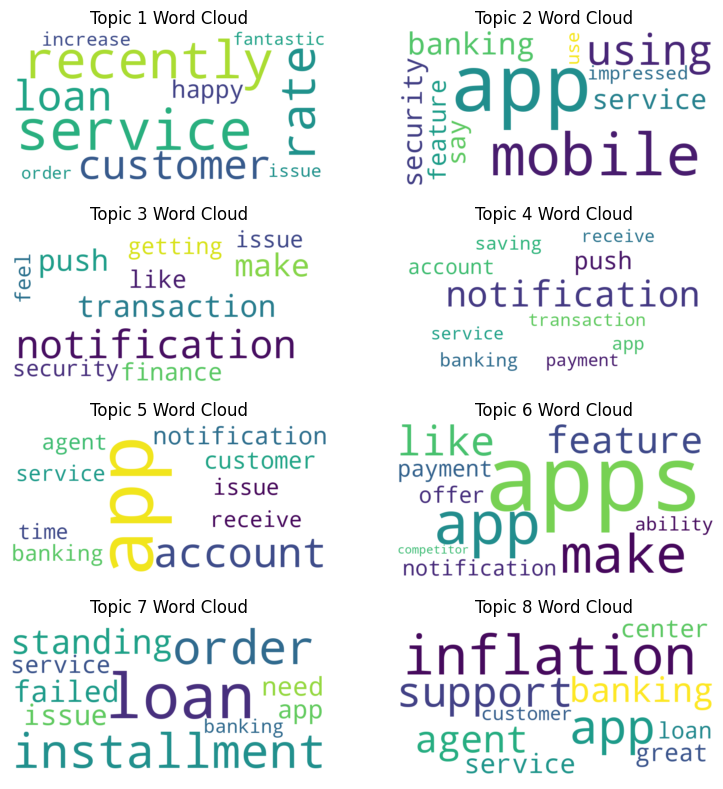

In [70]:
from wordcloud import WordCloud

# Set the number of rows and columns for the subplots
num_rows = 4
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Generate word clouds for each topic
for i, topic in enumerate(lda_model.get_topics()):
    word_freq = {feature_names[j]: topic[j] for j in topic.argsort()[:-num_words - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud on the corresponding subplot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Topic {i+1} Word Cloud')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

We can create a word cloud plot for the full dataset.

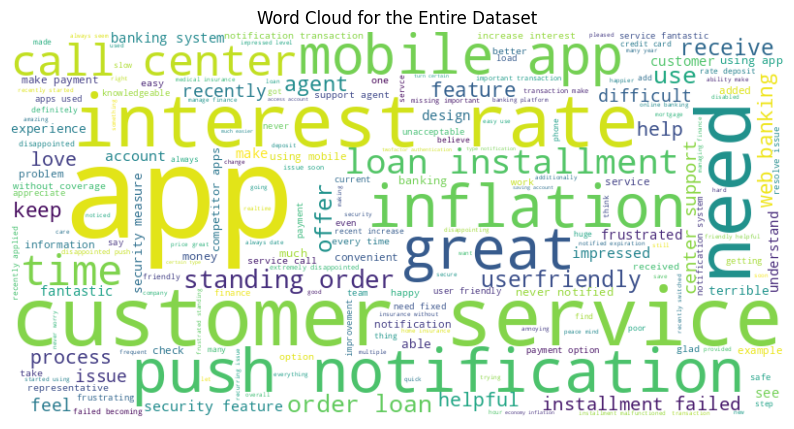

In [71]:
# Combine the text from all documents
combined_text = ' '.join(df['cleaned_review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the Entire Dataset')
plt.show()

In [72]:
# Create empty lists to store the dominant topic and its probability for each document
dominant_topics = []
topic_probabilities = []

# Iterate over each document
for i, document in enumerate(corpus):
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(document)
    # Sort the topic distribution in descending order by probability
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

    # Get the dominant topic and its probability
    dominant_topic = topic_distribution[0][0]
    topic_probability = topic_distribution[0][1]

    # Append the dominant topic and its probability to the respective lists
    dominant_topics.append(dominant_topic)
    topic_probabilities.append(topic_probability)

# Create a DataFrame to store the document index, dominant topic, and topic probability
document_topics = pd.DataFrame({'Document': range(len(corpus)),
                                'Dominant Topic': dominant_topics,
                                'Topic Probability': topic_probabilities})



Explore the dominant topic for each document and the corresponding topic probability

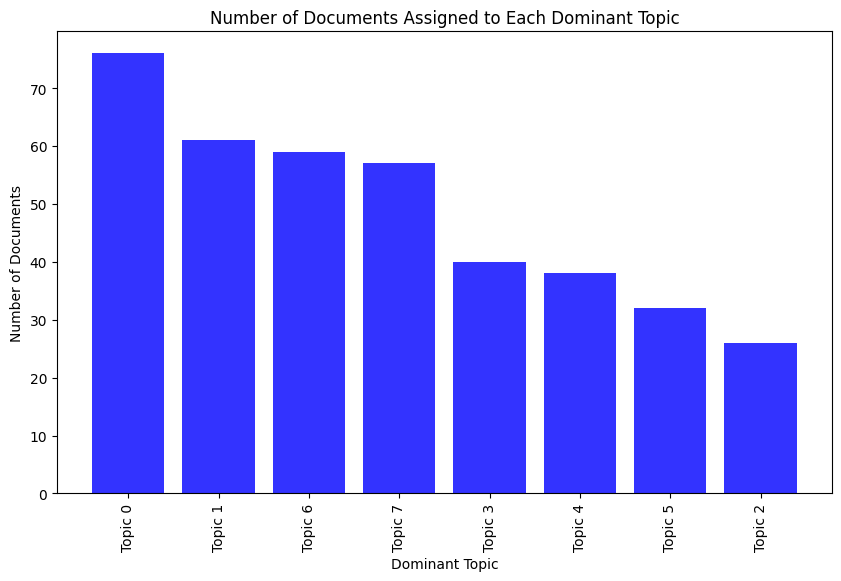

In [73]:
# Count the number of documents assigned to each dominant topic
topic_counts = document_topics['Dominant Topic'].value_counts()

# Sort the topics by count in descending order
sorted_topics = topic_counts.sort_values(ascending=False)

# Get the topic labels and counts
topic_labels = [f'Topic {topic}' for topic in sorted_topics.index]
topic_counts = sorted_topics.values

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_labels)), topic_counts, color='blue', alpha=0.8)
plt.xticks(range(len(topic_labels)), topic_labels, rotation='vertical')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.title('Number of Documents Assigned to Each Dominant Topic')
plt.show()

In [74]:
# Display the document topics
print(document_topics)

     Document  Dominant Topic  Topic Probability
0           0               7               0.85
1           1               0               0.93
2           2               0               0.49
3           3               4               0.63
4           4               0               0.89
..        ...             ...                ...
384       384               5               0.95
385       385               5               0.38
386       386               5               0.87
387       387               5               0.51
388       388               5               0.95

[389 rows x 3 columns]


Check the probabilities by topic

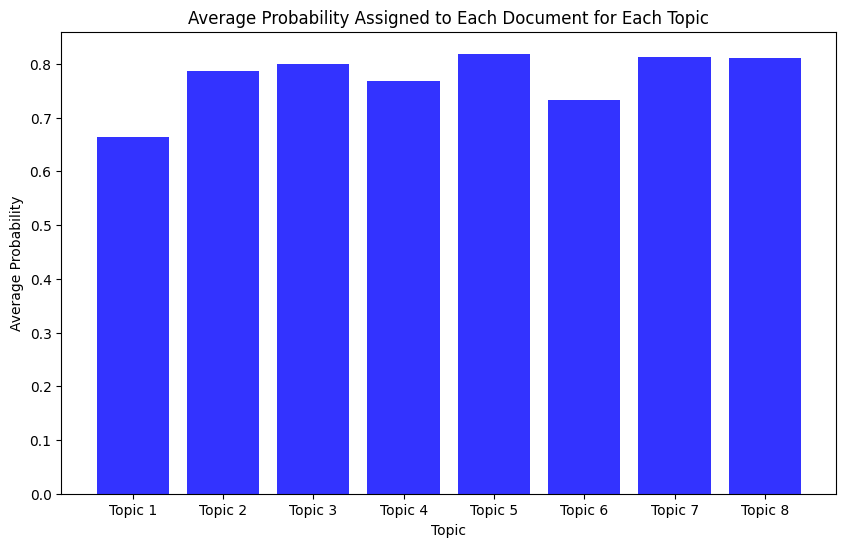

In [75]:
# Calculate the average probability for each topic across documents
topic_avg_probabilities = document_topics.groupby('Dominant Topic')['Topic Probability'].mean()

# Get the topic labels
topic_labels = [f'Topic {i+1}' for i in range(num_topics)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(num_topics), topic_avg_probabilities, color='blue', alpha=0.8)
plt.xticks(range(num_topics), topic_labels)
plt.xlabel('Topic')
plt.ylabel('Average Probability')
plt.title('Average Probability Assigned to Each Document for Each Topic')
plt.show()

All topics (except topic one) have probabilities higher than 0.7. I think it shows that our method is robust.

Topic coherence is a measure that assesses the interpretability and quality of the generated topics. It helps determine how semantically coherent the words within each topic are. Here's an example code snippet to calculate the topic coherence using the c_v coherence measure

In [76]:
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize

# Preprocess the documents and tokenize them
processed_docs = [word_tokenize(preprocess_text(doc)) for doc in df['review']]

# Create the Gensim dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create the corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Calculate topic coherence
coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
topic_coherence = coherence_model.get_coherence()

print(f"Topic Coherence: {topic_coherence}")

Topic Coherence: 0.7675733727477951


A coherence score of  about 0.77 is generally considered good, indicating that the topics have a reasonable level of coherence. However, the interpretation of the coherence score depends on the specific dataset and domain.

# Second question is to create a classification model to predict the rating

Create a new rating column with 3 values bad, ok, good.

In [77]:
unique_ratings = df['rating'].unique()
rating_counts = df['rating'].value_counts()

print("Unique Ratings:")
print(unique_ratings)

print("\nRating Counts:")
print(rating_counts)

Unique Ratings:
[5 2 4 1 3]

Rating Counts:
5    126
2    103
1     85
3     38
4     37
Name: rating, dtype: int64


We observe that most of the comments have rating = 5.

Preprocess data to prepare the dataset that will be used for the modelling phase.

In [126]:
# Create a new column 'rating_new' based on 'rating' values
df['rating_new'] = df['rating'].apply(lambda x: 'bad' if x in [1, 2] else 'ok' if x == 3 else 'good')

Create X and y dataset

In [127]:
X = df['cleaned_review']  # Extract the cleaned_review column as the feature matrix
y = df['rating_new']  # Extract the rating column as the target variable

Split the dataset

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create a CountVectorizer object to convert text into numerical features

In [129]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Check many different classification problems

In [130]:
from scipy.sparse import csr_matrix

# Convert sparse matrices to dense arrays
X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()

# Model
model = LazyClassifier(verbose=0, classifiers='all')
list_of_models, sentiment = model.fit(X_train_vec_dense, X_test_vec_dense, y_train, y_test)

100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


Compare the models.

In [131]:
print(list_of_models)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
Perceptron                         0.78               0.71    None      0.78   
LinearSVC                          0.77               0.67    None      0.77   
SGDClassifier                      0.81               0.66    None      0.80   
LinearDiscriminantAnalysis         0.74               0.65    None      0.74   
NearestCentroid                    0.78               0.64    None      0.77   
ExtraTreesClassifier               0.77               0.63    None      0.76   
LogisticRegression                 0.77               0.63    None      0.76   
PassiveAggressiveClassifier        0.72               0.63    None      0.71   
RidgeClassifier                    0.76               0.62    None      0.75   
RidgeClassifierCV                  0.74               0.62    None      0.73   
GaussianNB                         0.63 

In [107]:
import plotly.express as px
list_of_models.sort_values(by = 'F1 Score',inplace = True,ascending = False)
line = px.line(data_frame= list_of_models ,y =["F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "F1 Score")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'F1 Score Models Comparison'})

line.show()

SGDClassifier has the best F1 Score. I will tune the parameters.

In [108]:
# Define the parameter grid for tuning
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000, 3000]
}

# Create the SGDClassifier model
model = SGDClassifier(random_state=42)

# Perform grid search cross-validation to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_vec_dense, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set
y_pred = best_model.predict(X_test_vec_dense)

In [109]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7564102564102564
Precision: 0.7022589965852376
Recall: 0.6247276688453159
F1 Score: 0.6413632672767572


In [110]:
# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[32  2  2]
 [ 9 25  0]
 [ 6  0  2]]


We should check the confusion matrix for model's performance. The model's performance is dissapointing when predicting the 'ok' ratings.

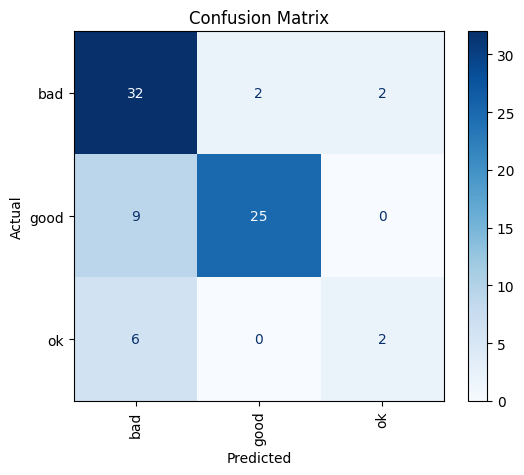

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
labels = ['bad', 'ok', 'good']  # Default labels if not available

# Extract labels from data or confusion matrix
try:
    labels = y_test.unique().tolist()  # Use unique labels from y_test if available
except AttributeError:
    try:
        labels = y_pred.unique().tolist()  # Use unique labels from y_pred if available
    except AttributeError:
        try:
            labels = confusion_mat.diagonal().tolist()  # Use diagonal values from confusion matrix if available
        except AttributeError:
            pass

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**We should also check the logistic regression model.**

In [115]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer


# Encode the ordinal target variable
encoder = OrdinalEncoder(categories=[['bad', 'ok', 'good']])
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Model
model = LogisticRegression()
model.fit(X_train_vec, y_train_encoded)

# Predict on the test set
y_pred_encoded = model.predict(X_test_vec)

# Decode the predicted values
y_pred = encoder.inverse_transform(y_pred_encoded.reshape(-1, 1)).flatten()

In [116]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7692307692307693
Precision: 0.7080745341614906
Recall: 0.6345315904139434
F1 Score: 0.6508436052102456


In [117]:
# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[32  2  2]
 [ 8 26  0]
 [ 6  0  2]]


The results are similar to the previous model's.

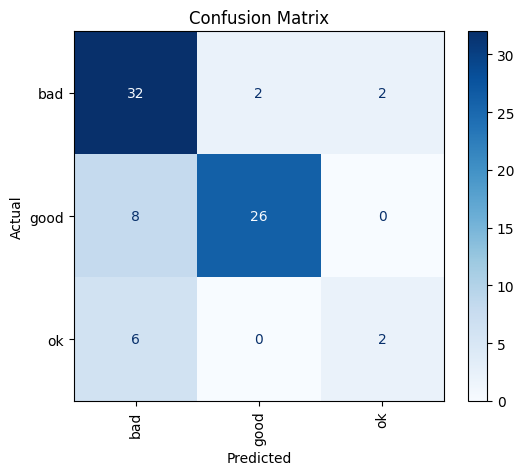

In [118]:
# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
labels = ['bad', 'ok', 'good']  # Default labels if not available

# Extract labels from data or confusion matrix
try:
    labels = y_test.unique().tolist()  # Use unique labels from y_test if available
except AttributeError:
    try:
        labels = y_pred.unique().tolist()  # Use unique labels from y_pred if available
    except AttributeError:
        try:
            labels = confusion_mat.diagonal().tolist()  # Use diagonal values from confusion matrix if available
        except AttributeError:
            pass

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()